In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, resample, windows, convolve
from scipy.optimize import curve_fit
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from copy import copy
import time
from glob import glob
from natsort import natsorted

%matplotlib widget

In [2]:
M_pxs, N_pxs = 20, 20

In [3]:
xfiles = natsorted(glob('./mapping_20x20/*x0*_*2023.npy'))
yfiles = natsorted(glob('./mapping_20x20/*y0*_*2023.npy'))
dark_s21 = np.load(glob('./mapping_20x20/*2023*dark.npy')[0])
freqs = np.load(glob('./mapping_20x20/*2023*freqs.npy')[0])
print(len(xfiles), len(yfiles))

45 45


394


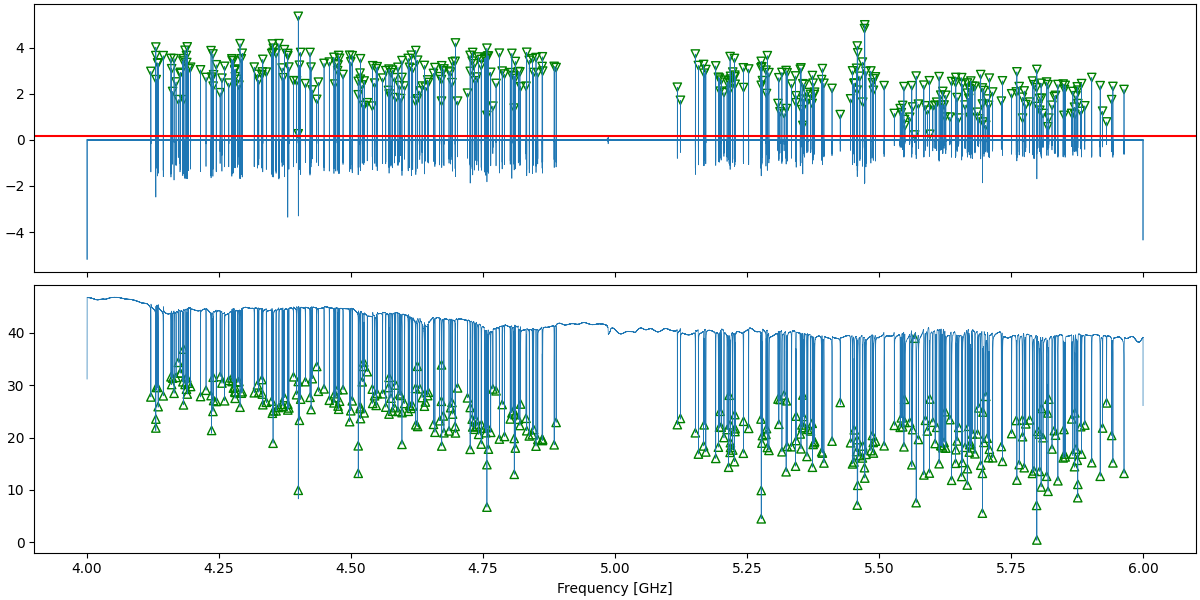

In [4]:
sw = 3 # even number
mph = 0.15
window = np.ones(sw)/sw
smooth_s21 = convolve(dark_s21, window, mode='same')
ds21 = np.diff(smooth_s21, 1)
smooth_ds21 = convolve(ds21, window, mode='same')
d2s21 = np.diff(smooth_ds21, 1)

locs, props = find_peaks(d2s21, height=mph, prominence=mph)
heights = props['peak_heights']

locs += 1
f0s = freqs[locs]
s21_mins = smooth_s21[locs]
fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(12, 6), constrained_layout=True)
ax['a'].plot(freqs[:-2], d2s21, lw=.5)
ax['b'].plot(freqs, smooth_s21, lw=.5)
ax['a'].axhline(mph, c='r')

ax['a'].scatter(freqs[:-2][locs-1], heights, marker='v', c='None', edgecolor='g')
ax['b'].scatter(f0s, s21_mins, marker='^', c='None', edgecolor='g')
ax['b'].set_xlabel('Frequency [GHz]')
print(len(locs))

In [5]:
nr_steps = len(xfiles)
nr_kids = len(locs)
s21s = np.empty((nr_steps, nr_kids, 2))
s21s[:] = np.nan
smooth_dark_s21 = convolve(dark_s21, window, mode='same')
smoothed_sweeps = np.empty((nr_steps, len(freqs), 2))
smooth_dark_s21 = convolve(dark_s21, window, mode='same')
s0 = s21_mins
for i, file in enumerate(xfiles):
    s21 = np.load(file)
    smooth_s21 = convolve(s21, window, mode='same')
    s21s[i, :, 0]  = smooth_s21[locs] - s0 
    smoothed_sweeps[i, :, 0] = smooth_s21

for i, file in enumerate(yfiles):
    s21 = np.load(file)
    smooth_s21 = convolve(s21, window, mode='same')
    s21s[i, :, 1]  = smooth_s21[locs] - s0 
    smoothed_sweeps[i, :, 1] = smooth_s21

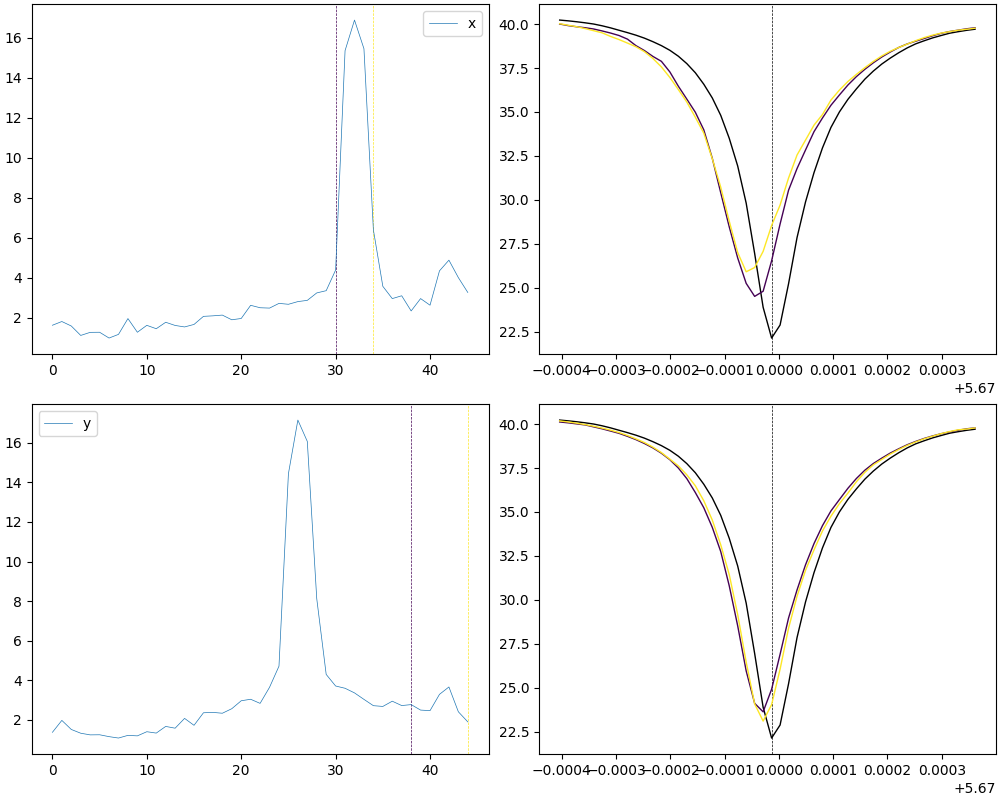

In [6]:
ids = np.arange(376, dtype=int)
ids = [324]
fig, ax = plt.subplot_mosaic('ab;cd', figsize=(10, 8), constrained_layout=True)
start = 0
stop = 20
# steps = np.arange(start, stop)
xsteps = [30, 34]
ysteps = [38, 44]
bw = 25
xcolors = plt.cm.viridis(np.linspace(0, 1, len(xsteps)))
ycolors = plt.cm.viridis(np.linspace(0, 1, len(ysteps)))
for id in ids:
    res = f0s[id]
    loc = locs[id]
    ax['b'].plot(freqs[loc-bw:loc+bw], smooth_dark_s21[loc-bw:loc+bw], lw=1, c='k', label='dark')
    ax['b'].axvline(res, c='k', ls='--', lw=.5)
    ax['d'].plot(freqs[loc-bw:loc+bw], smooth_dark_s21[loc-bw:loc+bw], lw=1, c='k', label='dark')
    ax['d'].axvline(res, c='k', ls='--', lw=.5)
    for i, step in enumerate(xsteps):
        ax['b'].plot(freqs[loc-bw:loc+bw], smoothed_sweeps[step, loc-bw:loc+bw, 0], lw=1, label=str(step), c=xcolors[i])
        ax['a'].axvline(step, ls='--', lw=.5, c=xcolors[i])
    for i, step in enumerate(ysteps):
        ax['d'].plot(freqs[loc-bw:loc+bw], smoothed_sweeps[step, loc-bw:loc+bw, 1], lw=1, label=str(step), c=ycolors[i])
        ax['c'].axvline(step, ls='--', lw=.5, c=ycolors[i])
    ax['a'].plot(s21s[:, id, 0], lw=.5, label='x')
    ax['c'].plot(s21s[:, id, 1], lw=.5, label='y')
ax['a'].legend()
ax['c'].legend()
# ax['a'].legend()

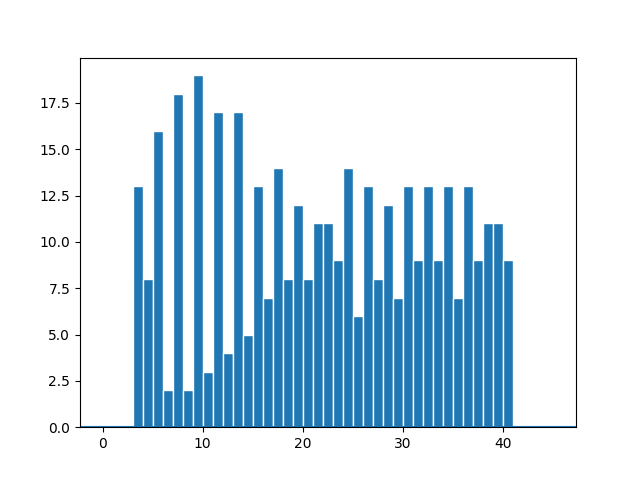

In [7]:
pos = np.empty((nr_kids,7)) # columns: meas idx, meas f0, x, y, design idx, design f0, design finger length
pos[:] = np.nan
pos[:, 0] = np.arange(nr_kids, dtype=int)
pos[:, 1] = f0s   #sd
for i in range(nr_kids):#|
    pos[i, 2] = np.nanargmax(s21s[:, i, 0])
    pos[i, 3] = np.nanargmax(s21s[:, i, 1])
fig, ax = plt.subplots()  
_ = ax.hist(pos[:, 3], bins=np.arange(nr_steps+1), facecolor='tab:blue', edgecolor='w')
ax.axhline()

[102 117]
[  9 165]
[225 226]
[334 335]
[158 347]


C:\Users\wilbertr\AppData\Local\Temp\ipykernel_31560\2902040992.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax['c'].scatter(pos[:, 2], pos[:, 3], c='y', cmap='viridis')


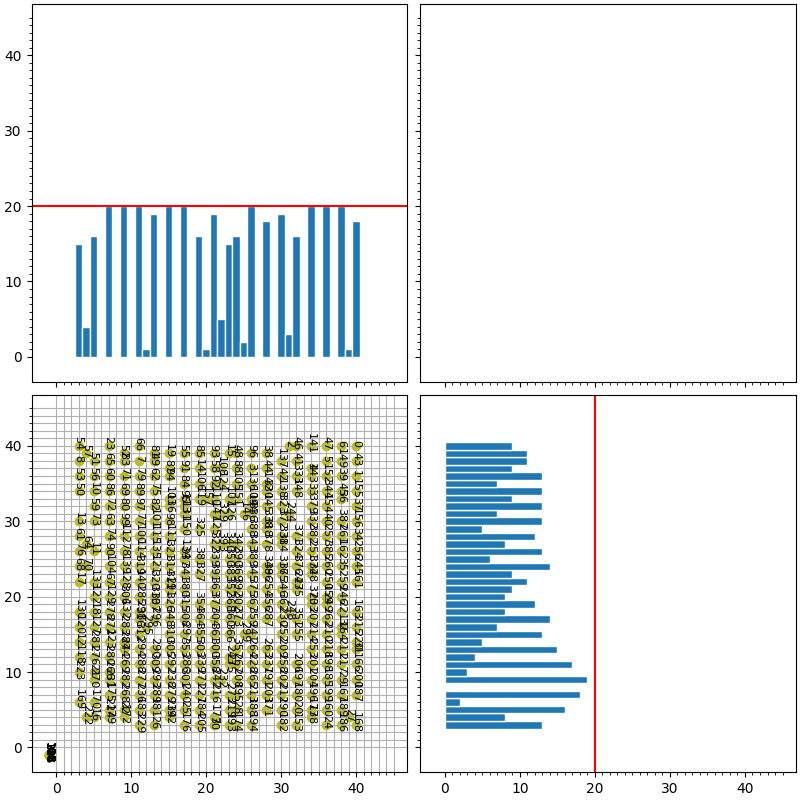

In [8]:
unique_idx, counts = np.unique(pos[:, 2:4], return_counts=True, return_index=True, axis=0)[1:]
doubles = np.ones(nr_kids).astype(bool)
doubles[unique_idx] = 0
double_coord = pos[doubles, 2:4]
for coord in double_coord:
    idx = np.where((pos[:, 2] == coord[0]) & (pos[:, 3] == coord[1]))[0]
    print(idx)
    pos[idx, 2:4] = -1
fig, ax = plt.subplot_mosaic('ab;cd', figsize=(8, 8), constrained_layout=True, sharey=True, sharex=True)   
ax['c'].scatter(pos[:, 2], pos[:, 3], c='y', cmap='viridis')
for i, txt in enumerate(pos[:, 0]):
    ax['c'].annotate(int(txt), (pos[i, 2], pos[i, 3]+.3), fontsize=8, ha='center', va='center', rotation=-90)
ax['d'].hist(pos[:, 3], bins=np.arange(nr_steps+1)-.5, facecolor='tab:blue', edgecolor='w', orientation='horizontal')
ax['d'].axvline(M_pxs, c='r')
ax['a'].hist(pos[:, 2], bins=np.arange(nr_steps+1)-.5, facecolor='tab:blue', edgecolor='w')
ax['a'].axhline(N_pxs, c='r')
ax['c'].set_xticks(np.arange(nr_steps+1), minor=True)
ax['c'].set_yticks(np.arange(nr_steps+1), minor=True)
ax['c'].grid(which='both')


C:\Users\wilbertr\AppData\Local\Temp\ipykernel_31560\3619384563.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax['c'].scatter(pos[:, 2], pos[:, 3], c='y', cmap='viridis')


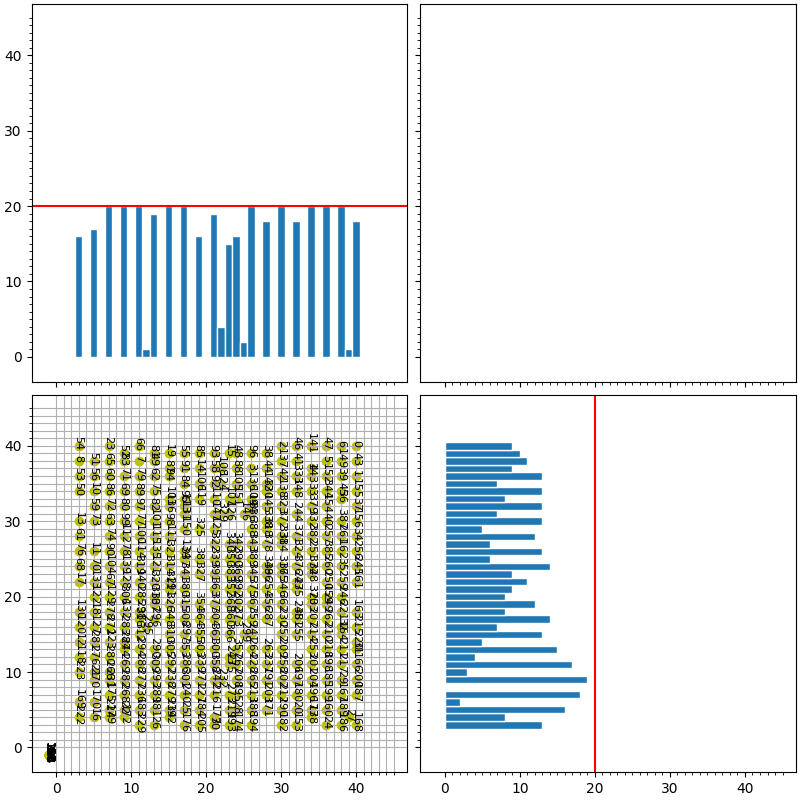

In [9]:
pos[222,2] = 3
pos[70,2] = 5
pos[57, 2:4] = -1
pos[64, 2:4] = -1
pos[2, 2] = 30
pos[244, 2] = 32
pos[248, 2] = 32
pos[157, 2:4] = -1
# pos[108, 2] = 23
# pos[124, 2] = 23
pos[393, 2:4] = -1
# pos[323, 2] = 23
# pos = np.delete(pos, [57, 64], axis=0)
fig, ax = plt.subplot_mosaic('ab;cd', figsize=(8, 8), constrained_layout=True, sharey=True, sharex=True)   
ax['c'].scatter(pos[:, 2], pos[:, 3], c='y', cmap='viridis')
for i, txt in enumerate(pos[:, 0]):
    ax['c'].annotate(int(txt), (pos[i, 2], pos[i, 3]+.3), fontsize=8, ha='center', va='center', rotation=-90)
ax['d'].hist(pos[:, 3], bins=np.arange(nr_steps+1)-.5, facecolor='tab:blue', edgecolor='w', orientation='horizontal')
ax['d'].axvline(M_pxs, c='r')
ax['a'].hist(pos[:, 2], bins=np.arange(nr_steps+1)-.5, facecolor='tab:blue', edgecolor='w')
ax['a'].axhline(N_pxs, c='r')
ax['c'].set_xticks(np.arange(nr_steps+1), minor=True)
ax['c'].set_yticks(np.arange(nr_steps+1), minor=True)
ax['c'].grid(which='both')

C:\Users\wilbertr\AppData\Local\Temp\ipykernel_31560\4180599317.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax['c'].scatter(pos[:, 2], pos[:, 3], c='y', cmap='viridis')


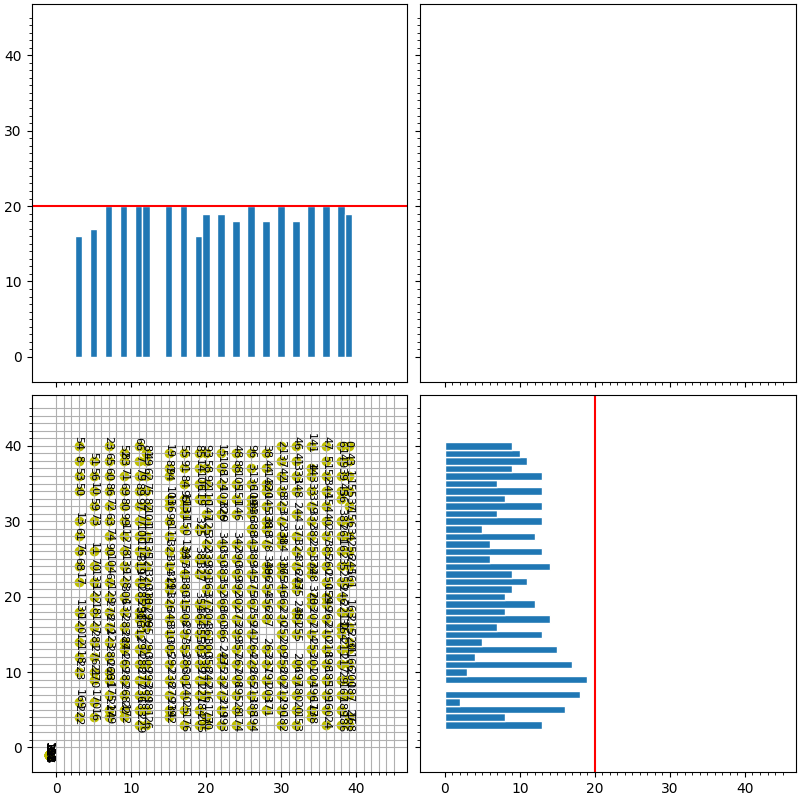

In [10]:
xs = np.array([-1, 3, 5, 7, 9, 11, 12.5, 15, 17, 19, 20.5, 22.5, 24.5, 26, 28, 30, 32, 34, 36, 38, 39.5])
for id, kid in enumerate(pos):
    kid[2] = int(xs[np.argmin(np.abs(xs - kid[2]))])
fig, ax = plt.subplot_mosaic('ab;cd', figsize=(8, 8), constrained_layout=True, sharey=True, sharex=True)

ax['c'].scatter(pos[:, 2], pos[:, 3], c='y', cmap='viridis')
for i, txt in enumerate(pos[:, 0]):
    ax['c'].annotate(int(txt), (pos[i, 2], pos[i, 3]+.3), fontsize=8, ha='center', va='center', rotation=-90)
ax['d'].hist(pos[:, 3], bins=np.arange(nr_steps+1)-.5, facecolor='tab:blue', edgecolor='w', orientation='horizontal')
ax['d'].axvline(M_pxs, c='r')
ax['a'].hist(pos[:, 2], bins=np.arange(nr_steps+1)-.5, facecolor='tab:blue', edgecolor='w')
ax['a'].axhline(N_pxs, c='r')
ax['c'].set_xticks(np.arange(nr_steps+1), minor=True)
ax['c'].set_yticks(np.arange(nr_steps+1), minor=True)
ax['c'].grid(which='both')

In [11]:
kids_all = np.empty((nr_steps, nr_steps))
kids_all[:] = np.nan    
for kid in pos:
    if np.isnan(kids_all[int(kid[3]), int(kid[2])]):
        if( kid[3] != -1) or (kid[2] != -1):   
            kids_all[int(kid[3]), int(kid[2])] = kid[0]
        else:
            print('0: ', kid)
    else:
        kids_all[int(kid[3]), int(kid[2])] = 1000
        kids_all[int(kid[3]-.5), int(kid[2])] = 1000
        print('overlapping:', kid)
kids_all[20, 3] = 1000
kids_all[32, 3] = 1000
kids_all[7, 3] = 1000
kids_all[8, 3] = 1000
kids_all[40, 5] = 1000
kids_all[28, 5] = 1000
kids_all[7, 5] = 1000
kids_all[31, 19] = 1000
kids_all[30, 19] = 1000
kids_all[27, 19] = 1000
kids_all[21, 19] = 1000
kids_all[32, 20] = 1000
kids_all[29, 22] = 1000
kids_all[32, 24] = 1000
kids_all[29, 24] = 1000
kids_all[15, 28] = 1000
kids_all[3, 28] = 1000
kids_all[19, 32] = 1000
kids_all[13, 32] = 1000
kids_all[20, 39] = 1000

kids_all = kids_all[:, ~np.isnan(kids_all).all(axis=0)]
kids_all = kids_all[~np.isnan(kids_all).all(axis=1), :]

0:  [ 9.          4.16205407 -1.         -1.                 nan         nan
         nan]
0:  [57.          4.35226021 -1.         -1.                 nan         nan
         nan]
0:  [64.          4.38016232 -1.         -1.                 nan         nan
         nan]
0:  [102.           4.54026355  -1.          -1.                  nan
          nan          nan]
0:  [117.           4.59189652  -1.          -1.                  nan
          nan          nan]
0:  [157.           4.73565643  -1.          -1.                  nan
          nan          nan]
0:  [158.           4.73824979  -1.          -1.                  nan
          nan          nan]
0:  [165.           4.75734071  -1.          -1.                  nan
          nan          nan]
0:  [225.           5.27684172  -1.          -1.                  nan
          nan          nan]
0:  [226.           5.27691983  -1.          -1.                  nan
          nan          nan]
overlapping: [329.           5.67665737  

In [12]:
kids_reduced = np.empty((M_pxs, N_pxs))
kids_reduced[:] = np.nan
for i in range(N_pxs):
    col = kids_all[:, i]
    nr_kids = np.sum(~np.isnan(col))
    if nr_kids == M_pxs:
        kids_reduced[:, i] = col[~np.isnan(col)]
    else:
        print(i, nr_kids)
kids_reduced


array([[ 222.,   16.,  179.,  172.,  229.,   26.,  192.,  176.,  205.,
          30.,  193.,  174.,  194., 1000.,  182.,  153.,  178.,   24.,
         186.,  168.],
       [ 169.,  170.,  224.,   22.,  183.,  181.,  234.,   25.,  184.,
         177.,  219.,   28.,  188.,  171.,  190.,   20.,  173.,  160.,
         189.,   27.],
       [1000., 1000.,  175.,  268.,  236.,  289.,  279.,  240.,  227.,
         216.,  273.,  195.,  213.,  203.,  212.,  180.,  196.,  199.,
         167.,  187.],
       [1000.,  270.,  231.,  282.,  277.,  293.,  238.,  301.,  271.,
         242.,  232.,  208.,  265.,  191.,  202.,  197.,  204.,  185.,
          29.,  200.],
       [ 223.,   21.,  266.,  269.,  288.,  309.,  292.,  286.,  239.,
         358.,  275.,  267.,  228.,  237.,  258.,  206.,  201.,  198.,
         217.,  166.],
       [ 118.,  276.,  280.,  274.,  294.,  290.,  305.,  353.,  303.,
         300.,  243.,  357.,  264.,  263.,  209., 1000.,  253.,  218.,
         211.,   31.],
       [  

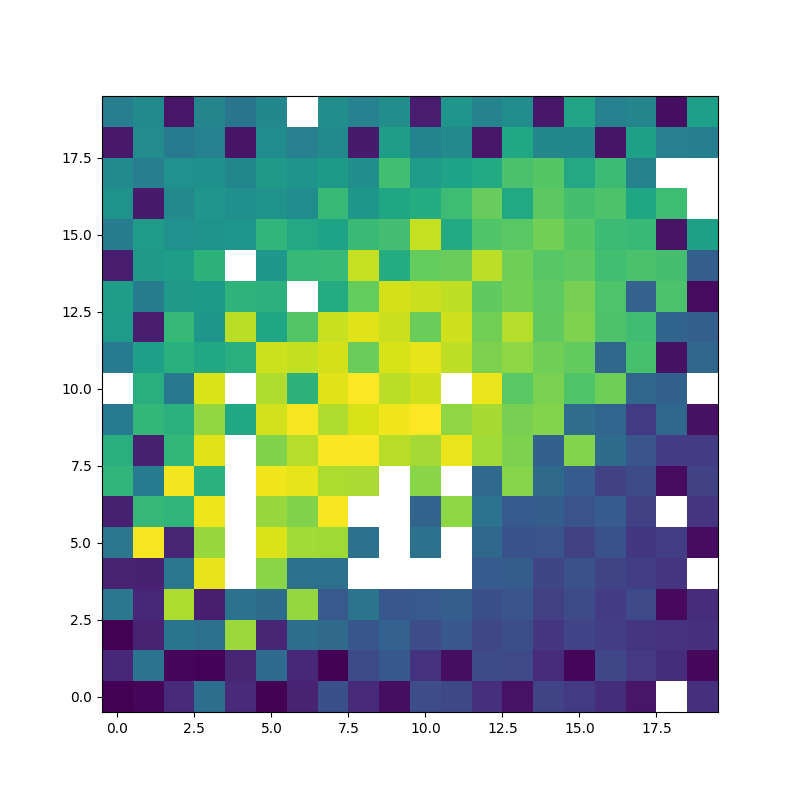

In [18]:
kids = np.flipud(np.fliplr(kids_reduced))
kids[kids==1000] = np.nan
# kids[0] = np.nan
# kids[-1] = np.nan
# kids[:, -1] = np.nan
# kids[5, 15] = np.nan
remove_ids = [247, 376, 324, 371, 244, 340]
for id in remove_ids:
    kids[kids == id] = np.nan
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(kids, cmap='viridis', origin='lower')

In [19]:
kid_id_board = np.load('KID_id_board_400.npy').astype(int)-1
# finger_length = np.load(r'.\LT361_4-8GHz_400px_fingers.npy')
# design_f0s = np.load('LEKID_EBEAM_F0s_5-7GHz.npy')*1e-9
design_f0s = np.load('LT295_FAB_F0s.npy')*1e-9
# design_f0s_original = np.load('LT361_FAB_F0s.npy')*1e-9
kid_id_board

array([[  0,   3,  44, 147,  48,   5,  46, 109,  50,   7,  92,  85,  52,
          9,  90,  69,  54,  11,  58,  61],
       [ 43, 148,   1,   4,  45, 146,  49,   6,  93, 108,  51,   8,  91,
         86,  53,  10,  89,  60,  55,  12],
       [  2,  39, 158, 149, 344,  47, 152, 145, 110, 121,  94, 107,  84,
         97,  68,  87,  70,  57,  62,  59],
       [159,  42, 345,  38, 157, 150, 343, 122, 153, 106, 111, 120,  95,
        104,  83,  98,  67,  88,  13,  56],
       [ 40,  37, 160, 387, 346, 341, 156, 151, 144, 123, 154, 105, 112,
        119,  96, 103,  82,  71,  66,  63],
       [161, 386,  41, 340, 255, 388, 349, 342, 155, 324, 143, 118, 125,
        102, 113,  78,  99,  64,  81,  14],
       [ 36, 257, 254, 389, 384, 347, 336, 399, 350, 333, 124, 325, 142,
        117, 126, 101, 114,  79,  72,  65],
       [253, 162, 385, 256, 339, 396, 391, 348, 335, 398, 323, 332, 127,
        326, 141, 116,  77, 100,  15,  80],
       [248,  35, 258, 383, 390, 337, 368, 397, 392, 351, 334, 3

In [20]:
nanmask = np.isnan(kids)
design = design_f0s[kid_id_board[~nanmask]]
# original = design_f0s_original[kid_id_board[~nanmask]]
meas = f0s[kids[~nanmask].astype(int)]
df_f = (design-meas) / design
print(np.std(df_f))

0.004219913287652104


line
0.0045289382912934205


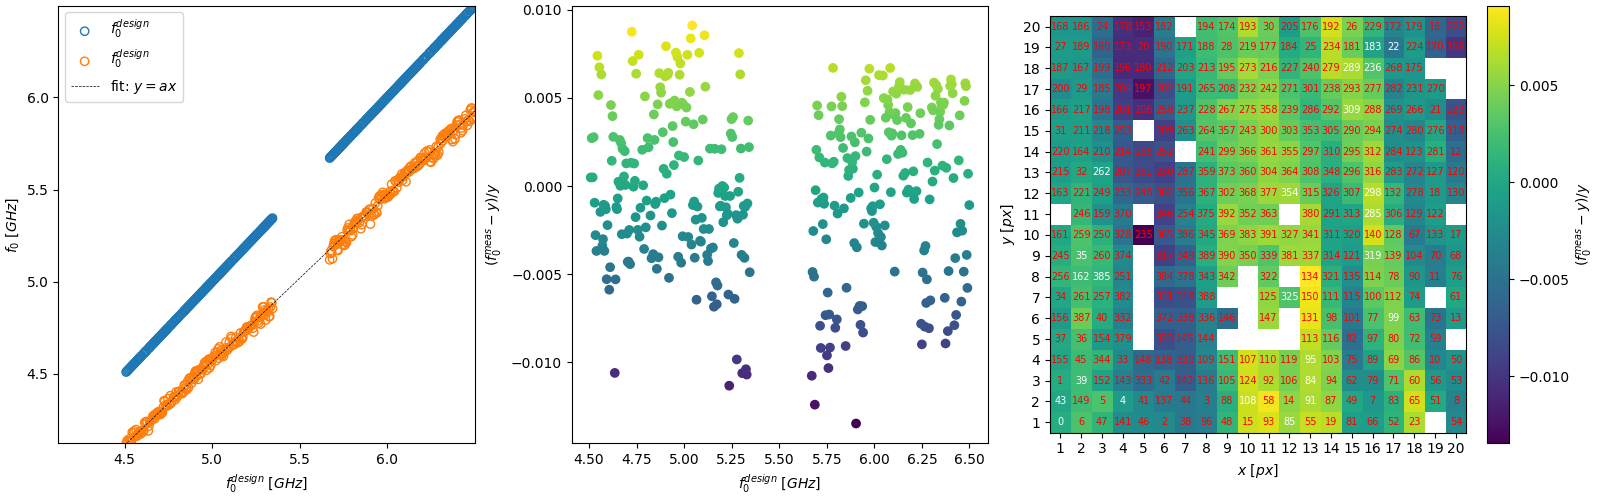

In [21]:
def linear(x, a, b):
    return a*x+b

def secorder(x, a, b, c):
    return a*x**2+b*x + c

def thirdorder(x, a, b, c, d):
    return a*x**3+b*x**2 + c*x + d

line = linear
popt, pcov = curve_fit(line, design.flatten(), meas.flatten())
meas_fit = line(design, *popt)
df_f_corr = (meas - meas_fit) / meas_fit
df_fmap = np.empty((M_pxs, N_pxs))
df_fmap[:] = np.nan
count = 0
for i, row in enumerate(kids):
    for j, k in enumerate(row):
        if ~np.isnan(k):
            df_fmap[i, j] = df_f_corr[count]
            count+=1
flim = np.array([np.min((design, meas)), np.max((design, meas))])

if line:
    if line == linear:
        eq = 'y=ax'
        save = 'fit_linear'
    elif line == secorder:
        eq = 'y=ax^2+bx'
        save = 'fit_secorder'
    elif line == thirdorder:
        eq = 'y=ax^3+bx^2+cx+d'
        save = 'fit_thirdorder'
    print('line')
    popt, pcov = curve_fit(line, design.flatten(), meas.flatten())
    fit = line(design, *popt)
    xfit = np.linspace(flim[0], flim[1])
    yfit = line(xfit, *popt)
    label = 'y'
else:
    fit = design
    label = 'f_0^{design}'
    save = 'nofit'
size=M_pxs


fig, ax = plt.subplot_mosaic('abc', figsize=(16, 5), constrained_layout=True)
ax['a'].scatter(design, design, c='None', edgecolor='tab:blue', label='$\it f_0^{design}$')
ax['a'].scatter(design, meas, c='None', edgecolor='tab:orange', label='$\it f_0^{design}$')
# ax['a'].scatter(design, original, c='None', edgecolor='tab:gray', label='$\it f_0^{original}$')
if line:
    ax['a'].plot(xfit, yfit, c='k', label='fit: $%s$' % eq, ls='--', lw=0.5)
ax['a'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
ax['a'].set_ylabel('$\it f_0$ $[GHz]$')
ax['a'].set_xlim(flim)
ax['a'].set_ylim(flim)
ax['a'].legend(loc='upper left')
ax['b'].scatter(design, df_f_corr, c=df_f_corr, label='residual, $f_0-y_2$')
# for i, x in enumerate(design):
#     ax['b'].annotate(i, (x, df_f_corr[i]), fontsize=8, ha='center', va='center')
ax['b'].annotate
ax['b'].set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
ax['b'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
im = ax['c'].imshow(df_fmap, cmap='viridis', origin='lower')
for i, x in enumerate(df_fmap):
    for j, y in enumerate(x):
        if ~np.isnan(y):
            old_id = kid_id_board[i, j]
            new_id = kids[i, j]
            if old_id == new_id:
                c = 'w'
            else:
                c = 'r'
            ax['c'].text(j, i, '%d' % new_id, ha='center', va='center', fontsize=7, color=c)
# Major ticks
ax['c'].set_xticks(np.arange(0, size, 1));
ax['c'].set_yticks(np.arange(0, size, 1));
# Labels for major ticks
ax['c'].set_xticklabels(np.arange(1, size+1, 1));
ax['c'].set_yticklabels(np.arange(1, size+1, 1));
# labels
ax['c'].set_xlabel('$\it x$ $[px]$')
ax['c'].set_ylabel('$\it y$ $[px]$')
cbar = fig.colorbar(im, ax=ax['c'])
# cbar.ax.invert_yaxis()
_ = cbar.ax.set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
# _ = cbar.ax.set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
print(np.std(df_fmap[1:-1, :-1][~np.isnan(df_fmap[1:-1, :-1])]))

In [ ]:
[247, 376, 324, 371, 244, 340]

(20, 20, 70)
(20, 20, 70)
(20, 20, 140)


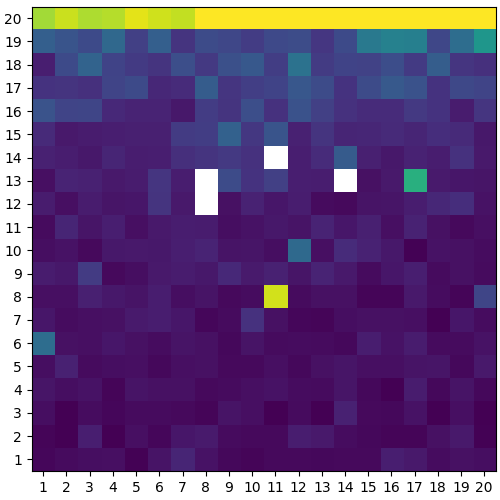

In [185]:
nr_scans = s21s.shape[0]

def map(axis=0):
    maps = np.zeros((M_pxs, N_pxs, nr_scans))
    for nr in range(nr_scans):
        for i, m in enumerate(kids):
            for j, k in enumerate(m):
                if ~np.isnan(k):
                    k = int(k)
                    s21s[:, k, axis] -= np.amin(s21s[:, k, axis])
                    s21s[:, k, axis] /= np.amax(s21s[:, k, axis])
                    maps[i, j, nr] = s21s[nr, int(k), axis]
                else:
                    maps[i, j, nr] = np.nan
    return maps
mapsx = map(axis=0)
print(mapsx.shape)
mapsy = map(axis=1)
print(mapsy.shape)
maps = np.concatenate((mapsx, mapsy), axis=2)
print(maps.shape)
fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
ax.imshow(maps[:, :, 75], origin='lower', cmap='viridis')
ax.set_xticks(np.arange(0, size, 1));
ax.set_yticks(np.arange(0, size, 1));
# Labels for major ticks
ax.set_xticklabels(np.arange(1, size+1, 1));
ax.set_yticklabels(np.arange(1, size+1, 1));


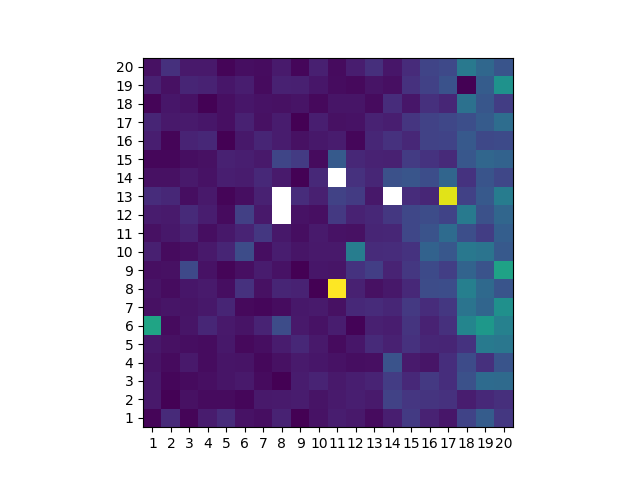

MovieWriter Pillow unavailable; using Pillow instead.


In [186]:
import matplotlib.animation as animation
nr_scans = maps.shape[2]
fig, ax = plt.subplots()
cax = ax.imshow(maps[:, :, 0], origin='lower', cmap='viridis')
ax.set_xticks(np.arange(0, size, 1));
ax.set_yticks(np.arange(0, size, 1));
# Labels for major ticks
ax.set_xticklabels(np.arange(1, size+1, 1));
ax.set_yticklabels(np.arange(1, size+1, 1));

def update(frame):
    cax.set_array(maps[:, :, frame])
    return cax,
ani = animation.FuncAnimation(fig, update, frames=nr_scans, interval=100, blit=True)
plt.show()
ani.save('animation_chip4.gif', writer='Pillow')